<a href="https://colab.research.google.com/github/markerenberg/Toxic-Comment-Classification/blob/master/NB_SVM_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check if GPU is enabled
import tensorflow as tf
tf.test.gpu_device_name()

In [1]:
##
## =======================================================
## Mark Erenberg 
## Toxic Comment Classification Challenge
## =======================================================
##

# Objective: Create a model which predicts a probability of each type of toxicity for each comment.

# import dependencies and files

import os
import time
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.sparse import hstack
import itertools
import matplotlib.pyplot as plt
import re, string
import tempfile
import warnings
import ast

import lightgbm as lgb

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize

import gensim
import gensim.models.keyedvectors as word2vec
from gensim.models.fasttext import FastText
from gensim.models.word2vec import Word2Vec

import spacy
import en_core_web_sm
spacy_nlp = en_core_web_sm.load()
spacy_nlp = spacy.load('en_core_web_sm')
from spacy.lemmatizer import Lemmatizer

from collections import Counter, defaultdict

from sklearn import utils
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Bidirectional, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.optimizers import Adam
from keras.callbacks import Callback

from imblearn.over_sampling import SMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

################### Data Loading ###################
#os.chdir('C:\\Users\\marke\\Downloads\\Toxic Classification')
train = pd.read_csv('train.csv').fillna('')
test = pd.read_csv('test.csv').fillna('')

train_text = train[['id','comment_text']].drop_duplicates()
df = pd.concat([train_text,test],axis=0,ignore_index=True)

################### Data Cleaning ####################
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
cv = CountVectorizer(min_df=0., max_df=1.)

# Simple way to get the number of occurence of a regex
def count_regexp_occ(regexp="", text=None):
    return len(re.findall(regexp, text))

# Determine if file words exist:
#print(len(df[df['comment_text'].str.contains('jpg')]))
#print(len(df[df['comment_text'].str.contains('jpeg')]))
#print(len(df[df['comment_text'].str.contains('http')]))
#print(len(df[df['comment_text'].str.contains('pdf')]))
#print(len(df[df['comment_text'].str.contains('html')]))

# Remove non-alphabetic characters and split tokens by spaces/newlines
def clean_document(doc):
    # 1) Convert string to lower
    #doc = bytes(doc.lower(), encoding="utf-8")
    doc = doc.lower()
    # 2) Replace contracion patterns
    cont_patterns = [
    (r'(W|w)on\'t', r'will not'),
    (r'(C|c)an\'t', r'can not'),
    (r'(I|i)\'m', r'i am'),
    (r'(A|a)in\'t', r'is not'),
    (r'(\w+)\'ll', r'\g<1> will'),
    (r'(\w+)n\'t', r'\g<1> not'),
    (r'(\w+)\'ve', r'\g<1> have'),
    (r'(\w+)\'s', r'\g<1> is'),
    (r'(\w+)\'re', r'\g<1> are'),
    (r'(\w+)\'d', r'\g<1> would'),
    ]
    patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]
    for (pattern, repl) in patterns:
        doc = re.sub(pattern, repl, doc)
    # 3) Remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]+', '', doc)
    #doc = doc.encode('utf-8')
    #doc = str(doc,'utf-8').strip()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    #doc = ' '.join(tokens)
    return doc

# Lemmaitze comments:
def lemmatize_comment(comment):
        doc = spacy_nlp(comment)
        return [token.lemma_ for token in doc if token.lemma_ != '-PRON-' ]         


## Clean and lemmatize comments
#df['clean_comments'] = [clean_document(x) for x in df['comment_text']]
#df['clean_comments_list'] = df['clean_comments'].apply(lambda x: x.split())
#df['clean_lemmed'] = [lemmatize_comment(x) for x in df['clean_comments']]
#df['clean_lemmed_str'] = df['clean_lemmed'].apply(lambda x: " ".join(x))
train['clean_comments'] = [clean_document(x) for x in train['comment_text']]
train['clean_comments_list'] = train['clean_comments'].apply(lambda x: x.split())
#train['clean_lemmed'] = [lemmatize_comment(x) for x in train['clean_comments']]
#train['clean_lemmed_str'] = train['clean_lemmed'].apply(lambda x: " ".join(x))

## Write to csv for download
#from google.colab import drive
#drive.mount('/content/drive')
#train['clean_comments'].to_csv('train_clean_comments.csv',sep=',',index=False)
#train['clean_lemmed'].to_csv('train_clean_lemmed.csv',sep=',',index=False)

## Read from csv
#train_clean_comments = pd.read_csv('train_clean_comments.csv',header=None)
#train_clean_lemmed = pd.read_csv('train_clean_lemmed.csv',header=None)

## Transform cleaned/lemmed strings
#train['clean_comments'] = train_clean_comments[0].apply(lambda x: str(x))
#train['clean_comments_list'] = train['clean_comments'].apply(lambda x: x.split())
#train['clean_lemmed'] = train_clean_lemmed[0].apply(lambda x: ast.literal_eval(x))
#train['clean_lemmed_str'] = train['clean_lemmed'].apply(lambda x: " ".join(x))

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from scipy import sparse
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, tol=1e-4, dual=False, n_jobs=1, multi_class='auto', class_weight='balanced', solver='lbfgs', max_iter=100):
        self.C = C
        self.tol=tol
        self.dual = dual
        self.n_jobs = n_jobs
        self.multi_class = multi_class
        self.class_weight= class_weight
        self.solver=solver
        self.max_iter = max_iter

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        #y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, 
                                       tol=self.tol, 
                                       dual=self.dual, 
                                       n_jobs=self.n_jobs, 
                                       multi_class=self.multi_class,
                                       class_weight=self.class_weight,
                                       solver=self.solver,
                                       max_iter=self.max_iter).fit(x_nb, y)
        return self

# Tokenizing function for TFIDF
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [ ]:
##### Fit NBSVM Model #####
warnings.filterwarnings("ignore")

train_features = train_tfidf_features

#class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
class_names = ['severe_toxic','threat','identity_hate']
seed = 1234
splits = 5
folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)

for i, j in enumerate(class_names):
    training_labels = train[j]
    class_pred = np.zeros(len(train))
    auc,precision,recall,thresholds = [],[],[],[]

    # Make predictions for each fold in split, calculate evaluation metrics
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_features, training_labels)):
      # Train NB-SVM
      model = NbSvmClassifier(C=4, tol=1e-4, dual=False, n_jobs=-1,multi_class='auto')
      model.fit(train_features[trn_idx], training_labels[trn_idx])
      class_pred[val_idx] = model.predict_proba(train_features[val_idx])[:,1]
      auc.append(roc_auc_score(training_labels[val_idx], class_pred[val_idx],average='weighted'))
      prec, recal, thresh = precision_recall_curve(training_labels[val_idx], class_pred[val_idx])
      precision.append(prec)
      recall.append(recal)
      thresholds.append(thresh)

    # Print out mean AUC score
    print("fit: ",j,' | mean AUC: ',str(round(np.mean(auc),4)))
    print("Thresholds: "+str(thresholds[4]))
    print("Precision: "+str(precision[4]))
    # Plot precision-recall curve
    plt.figure()
    plt.plot(recall[0], precision[0], 'ro', linewidth=2,label='Fold 1 Preds')
    plt.plot(recall[1], precision[1], 'bo', linewidth=2,label='Fold 2 Preds')
    plt.plot(recall[2], precision[2], 'go', linewidth=2,label='Fold 3 Preds')
    plt.plot(recall[3], precision[3], 'yo', linewidth=2,label='Fold 4 Preds')
    plt.plot(recall[4], precision[4], 'mo', linewidth=2,label='Fold 5 Preds')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Class: '+j+' | Average Precision: '+str(average_precision_score(training_labels,class_pred,average='weighted')))
    plt.legend()
    plt.show()
    



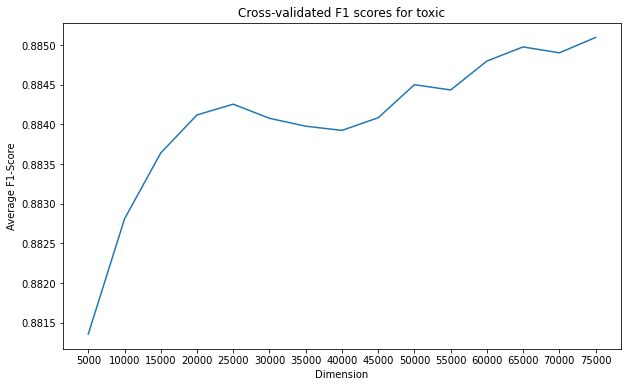

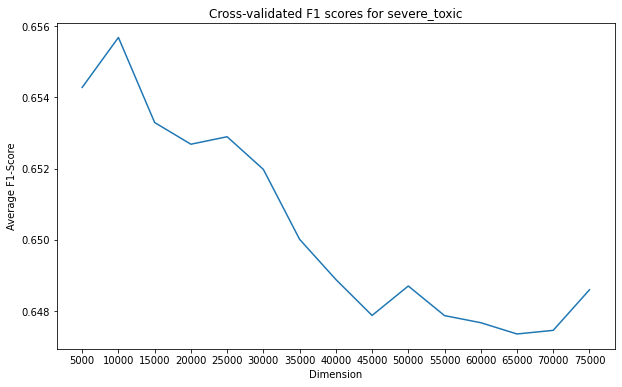

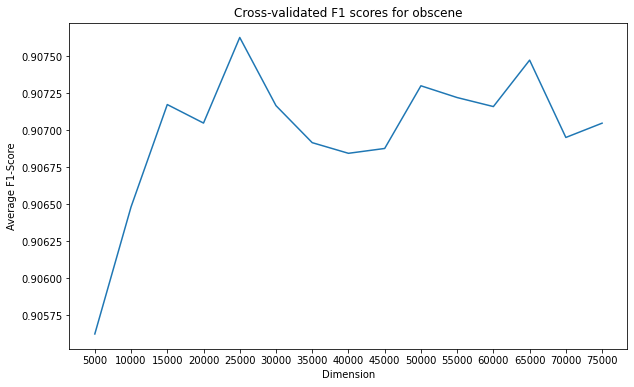

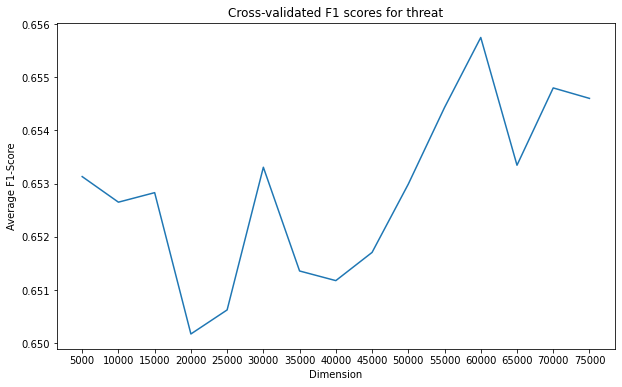

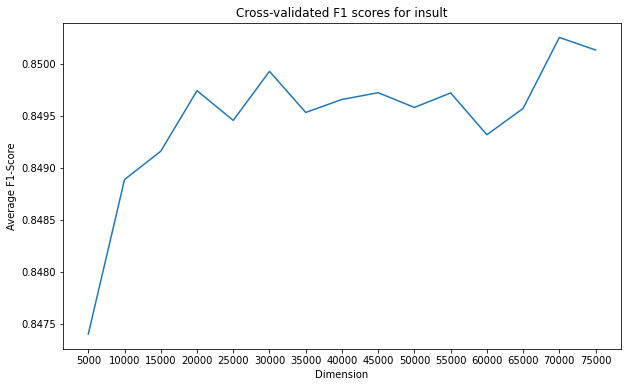

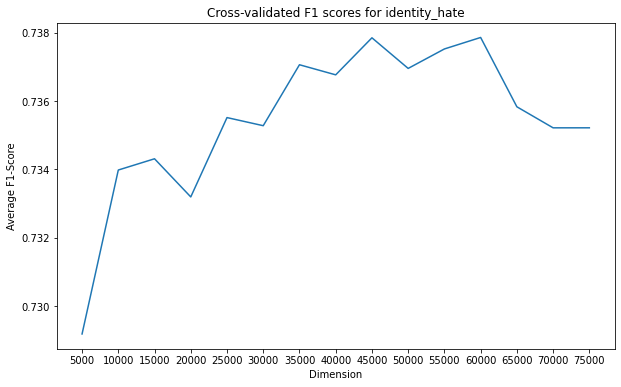

In [4]:
######### Test TFIDF character dimensions using cross-validation
# TF-IDF Vectorizer
train_text = train['clean_comments']
max_dict = {'toxic':25000,'severe_toxic':15000,'obscene':65000,'threat':25000,'insult':10000,'identity_hate':10000}

for resp in class_names:
  dimensions = np.arange(5000,80000,5000)
  scores=[]
  for dim in dimensions:
    word_vectorizer = TfidfVectorizer(
        ngram_range=(1, 2),
        tokenizer=tokenize,
        #min_df = 3,
        max_df = 0.9,
        strip_accents='unicode',
        analyzer='word',
        stop_words='english',
        use_idf=True,
        sublinear_tf=True,
        smooth_idf=True,
        max_features=max_dict[resp])
    char_vectorizer = TfidfVectorizer(
        ngram_range=(2, 6),
        #min_df = 3,
        max_df = 0.9,
        strip_accents='unicode',
        analyzer='char',
        stop_words='english',
        use_idf=True,
        sublinear_tf=True,
        smooth_idf=True,
        max_features=dim)
    word_features = word_vectorizer.fit_transform(train_text)
    char_features = char_vectorizer.fit_transform(train_text)
    train_features = hstack([word_features,char_features]).tocsr()
    training_labels = train[resp]
    seed = 1234
    splits = 3
    folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)
    class_pred = np.zeros(len(train))
    dim_scores=[]
    # Make predictions for each fold in split, calculate evaluation metrics
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_features, training_labels)):
      # Train NB-SVM
      model = NbSvmClassifier(C=4, tol=1e-4, dual=True, n_jobs=-1,multi_class='auto',class_weight='balanced',solver='liblinear',max_iter=1000)
      model.fit(train_features[trn_idx], training_labels[trn_idx])
      class_pred[val_idx] = model.predict_proba(train_features[val_idx])[:,1]
      prec, recal, thresh = precision_recall_curve(training_labels[val_idx], class_pred[val_idx])
      fscore = (2 * prec * recal) / (prec + recal)
      ix = np.argmax(fscore)
      preds=(class_pred[val_idx]>= thresh[ix]).astype(int)
      f1 = f1_score(training_labels[val_idx],preds,average='macro')
      dim_scores.append(f1)
    scores.append(np.mean(dim_scores))
  # Plot F1-Scores    
  plt.figure(figsize=(10,6))
  plt.plot(dimensions,scores)
  plt.xticks(dimensions)
  plt.title("Cross-validated F1 scores for {}".format(resp))
  plt.xlabel("Dimension")
  plt.ylabel("Average F1-Score")
  plt.show()


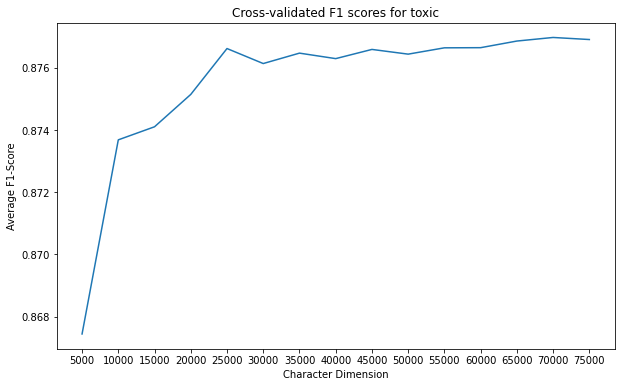

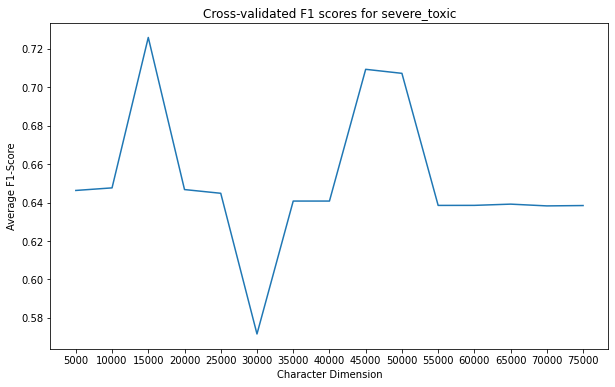

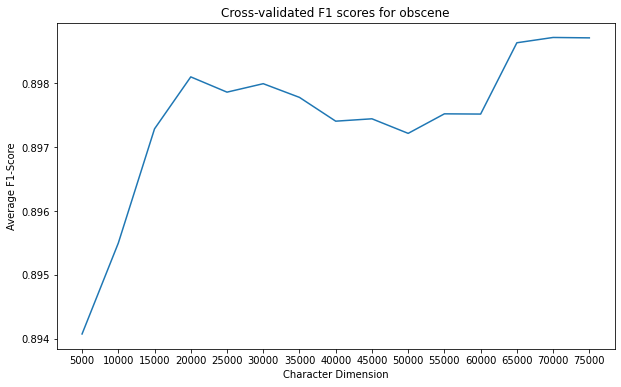

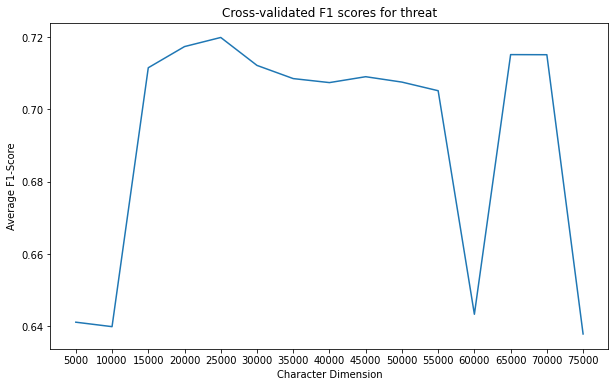

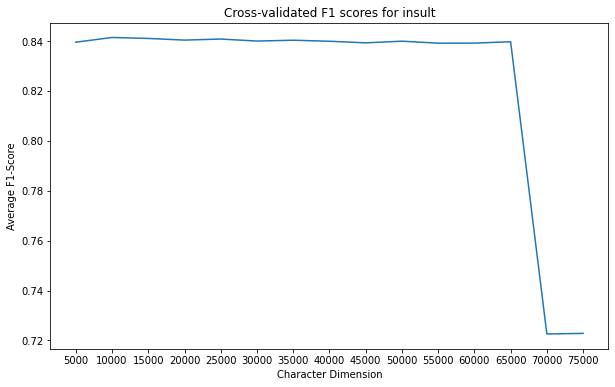

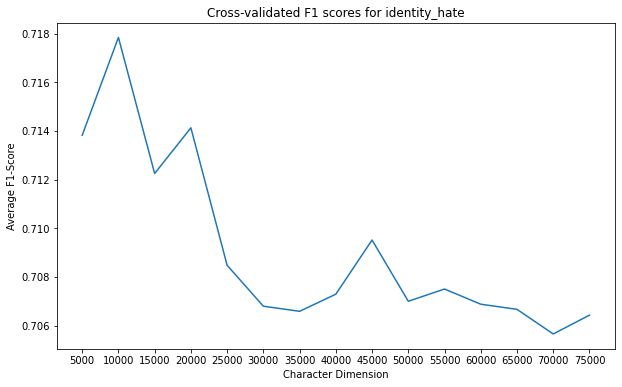

In [3]:
######### Test TFIDF word dimensions using cross-validation
# TF-IDF Vectorizer
train_text = train['clean_comments']

for resp in class_names:
  dimensions = np.arange(5000,80000,5000)
  scores=[]
  for dim in dimensions:
    word_vectorizer = TfidfVectorizer(
        ngram_range=(1, 2),
        tokenizer=tokenize,
        #min_df = 3,
        max_df = 0.9,
        strip_accents='unicode',
        analyzer='word',
        stop_words='english',
        use_idf=True,
        sublinear_tf=True,
        smooth_idf=True,
        max_features=dim)
    train_features = word_vectorizer.fit_transform(train_text)
    training_labels = train[resp]
    seed = 1234
    splits = 3
    folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)
    class_pred = np.zeros(len(train))
    dim_scores=[]
    # Make predictions for each fold in split, calculate evaluation metrics
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_features, training_labels)):
      # Train NB-SVM
      model = NbSvmClassifier(C=4, tol=1e-4, dual=True, n_jobs=-1,multi_class='auto',class_weight='balanced',solver='liblinear',max_iter=1000)
      model.fit(train_features[trn_idx], training_labels[trn_idx])
      class_pred[val_idx] = model.predict_proba(train_features[val_idx])[:,1]
      prec, recal, thresh = precision_recall_curve(training_labels[val_idx], class_pred[val_idx])
      fscore = (2 * prec * recal) / (prec + recal)
      ix = np.argmax(fscore)
      preds=(class_pred[val_idx]>= thresh[ix]).astype(int)
      f1 = f1_score(training_labels[val_idx],preds,average='macro')
      dim_scores.append(f1)
    scores.append(np.mean(dim_scores))
  # Plot F1-Scores    
  plt.figure(figsize=(10,6))
  plt.plot(dimensions,scores)
  plt.xticks(dimensions)
  plt.title("Cross-validated F1 scores for {}".format(resp))
  plt.xlabel("Character Dimension")
  plt.ylabel("Average F1-Score")
  plt.show()
